In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from keras.layers import TextVectorization, Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.models import Sequential
from keras.optimizers import Adam

In [53]:
DATASET_PATH = '../train_models/dataset/nusaX'

train_df = pd.read_csv(f'{DATASET_PATH}/train.csv')
valid_df = pd.read_csv(f'{DATASET_PATH}/valid.csv')
test_df = pd.read_csv(f'{DATASET_PATH}/test.csv')

label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['label'])
valid_df['label'] = label_encoder.transform(valid_df['label'])
test_df['label'] = label_encoder.transform(test_df['label'])

X_train, y_train = train_df['text'].values, train_df['label'].values
X_valid, y_valid = valid_df['text'].values, valid_df['label'].values
X_test, y_test   = test_df['text'].values,  test_df['label'].values
print(f'Train: {X_train.shape}, Valid: {X_valid.shape}, Test: {X_test.shape}')

Train: (500,), Valid: (100,), Test: (400,)


In [54]:
vocab_size = 10000
sequence_length = 100

vectorizer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length
)
vectorizer.adapt(X_train)

X_train_vec = vectorizer(X_train)
X_valid_vec = vectorizer(X_valid)
X_test_vec = vectorizer(X_test)
print(f'train {X_train_vec.shape}, valid {X_valid_vec.shape}, test {X_test_vec.shape}')

train (500, 100), valid (100, 100), test (400, 100)


In [55]:
def build_lstm_model(num_lstm_layers=1, lstm_units=64, bidirectional=False, dropout_rate=0.5, vocab_size=10000, embedding_dim=128, sequence_length=100, num_classes=3):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_length, mask_zero=True))
    for i in range(num_lstm_layers):
        return_sequences = (i < num_lstm_layers - 1)
        lstm_layer_instance = LSTM(lstm_units, return_sequences=return_sequences)
        if bidirectional:
            model.add(Bidirectional(lstm_layer_instance))
        else:
            model.add(lstm_layer_instance)
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy']
    )
    return model

In [56]:
def plot_multi_loss(histories, labels, title='Loss Curve'):
    plt.figure(figsize=(10, 6))
    prop_cycler = plt.rcParams['axes.prop_cycle']
    colors = prop_cycler.by_key()['color']

    for i, (h, label) in enumerate(zip(histories, labels)):
        color = colors[i % len(colors)] 
        train_line, = plt.plot(h.history['loss'], label=f'{label} train', color=color)
        plt.plot(h.history['val_loss'], linestyle='--', label=f'{label} val', color=train_line.get_color(), alpha=0.7)
        
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
def macro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

In [57]:
def train_lstm_model(model, X_train_vec, y_train, X_valid_vec, y_valid, X_test_vec, y_test, model_label):
    print(f'\nTraining {model_label}...')
    history = model.fit(
        X_train_vec, y_train,
        validation_data=(X_valid_vec, y_valid),
        epochs=10,
        batch_size=32,
        verbose=0
    )
    y_pred_proba = model.predict(X_test_vec)
    y_pred = np.argmax(y_pred_proba, axis=1)
    f1 = macro_f1(y_test, y_pred)
    print(f'Macro F1-score (test) for {model_label}: {f1:.4f}')
    return history, f1

## Hyperparameter Variations
### 6.1 Pengaruh Jumlah Layer LSTM

c:\Users\maula\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(



Training 1 layer...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Macro F1-score (test) for 1 layer: 0.7031

Training 2 Layers...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
Macro F1-score (test) for 2 Layers: 0.7108

Training 3 Layers...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
Macro F1-score (test) for 3 Layers: 0.7318


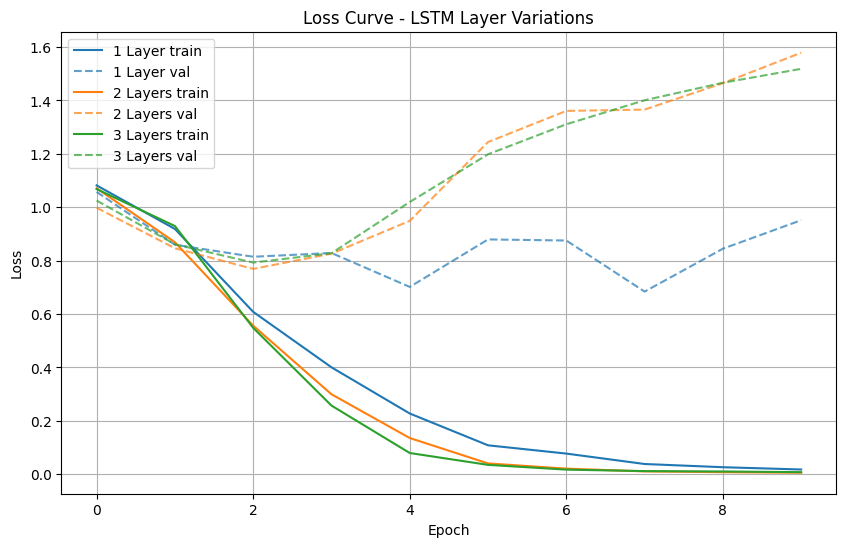

LSTM with 1 layer(s): Macro F1 = 0.7031
LSTM with 2 layer(s): Macro F1 = 0.7108
LSTM with 3 layer(s): Macro F1 = 0.7318


In [64]:
num_classes_val = len(label_encoder.classes_)
lstm_units_list_values = [1, 2, 3]

model_1_layer = build_lstm_model(num_lstm_layers=1, lstm_units=64, bidirectional=False, num_classes=num_classes_val)
model_2_layer = build_lstm_model(num_lstm_layers=2, lstm_units=64, bidirectional=False, num_classes=num_classes_val)
model_3_layer = build_lstm_model(num_lstm_layers=3, lstm_units=64, bidirectional=False, num_classes=num_classes_val)

hist_1, f1_1 = train_lstm_model(model_1_layer, X_train_vec, y_train, X_valid_vec, y_valid, X_test_vec, y_test, "1 layer")
hist_2, f1_2 = train_lstm_model(model_2_layer, X_train_vec, y_train, X_valid_vec, y_valid, X_test_vec, y_test, "2 Layers")
hist_3, f1_3 = train_lstm_model(model_3_layer, X_train_vec, y_train, X_valid_vec, y_valid, X_test_vec, y_test, "3 Layers")

histories_units_collected = [hist_1, hist_2, hist_3]
labels_units_collected = ["1 Layer", "2 Layers", "3 Layers"]
f1_scores_units_collected = [f1_1, f1_2, f1_3]

plot_multi_loss(histories_units_collected, labels_units_collected, title='Loss Curve - LSTM Layer Variations')

for units_val, f1_val in zip(lstm_units_list_values, f1_scores_units_collected):
    print(f'LSTM with {units_val} layer(s): Macro F1 = {f1_val:.4f}')

### 6.2 Pengaruh Banyak Cell LSTM per Layer


Training 32 LSTM Cells...


c:\Users\maula\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 558ms/step
Macro F1-score (test) for 32 LSTM Cells: 0.7390

Training 64 LSTM Cells...
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step
Macro F1-score (test) for 64 LSTM Cells: 0.7185

Training 128 LSTM Cells...
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
Macro F1-score (test) for 128 LSTM Cells: 0.7379


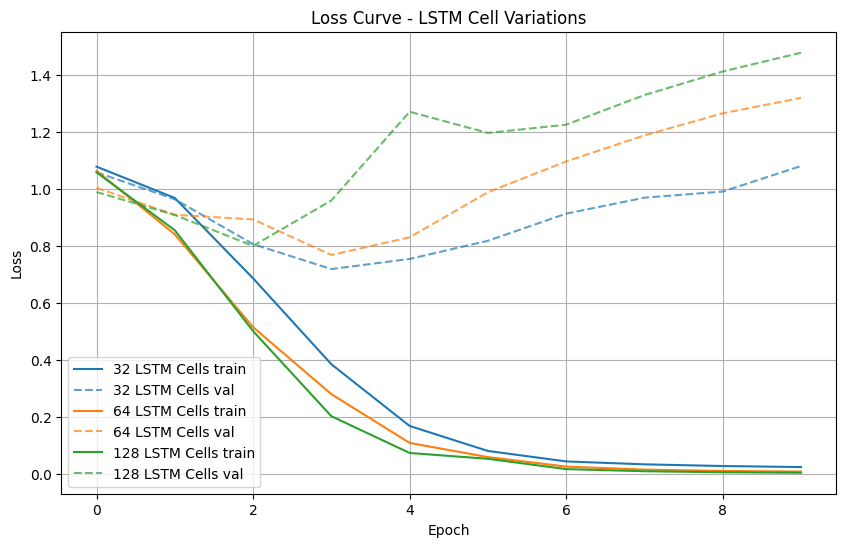

32 LSTM cell(s) per layer: Macro F1 = 0.7390
64 LSTM cell(s) per layer: Macro F1 = 0.7185
128 LSTM cell(s) per layer: Macro F1 = 0.7379


In [59]:
num_classes_val = len(label_encoder.classes_)
lstm_units_list_values = [32, 64, 128]

model_32_cells = build_lstm_model(num_lstm_layers=2, lstm_units=32, bidirectional=False, num_classes=num_classes_val)
model_64_cells = build_lstm_model(num_lstm_layers=2, lstm_units=64, bidirectional=False, num_classes=num_classes_val)
model_128_cells = build_lstm_model(num_lstm_layers=2, lstm_units=128, bidirectional=False, num_classes=num_classes_val)

hist_32, f1_32 = train_lstm_model(model_32_cells, X_train_vec, y_train, X_valid_vec, y_valid, X_test_vec, y_test, "32 LSTM Cells")
hist_64, f1_64 = train_lstm_model(model_64_cells, X_train_vec, y_train, X_valid_vec, y_valid, X_test_vec, y_test, "64 LSTM Cells")
hist_128, f1_128 = train_lstm_model(model_128_cells, X_train_vec, y_train, X_valid_vec, y_valid, X_test_vec, y_test, "128 LSTM Cells")

histories_units_collected = [hist_32, hist_64, hist_128]
labels_units_collected = ["32 LSTM Cells", "64 LSTM Cells", "128 LSTM Cells"]
f1_scores_units_collected = [f1_32, f1_64, f1_128]

plot_multi_loss(histories_units_collected, labels_units_collected, title='Loss Curve - LSTM Cell Variations')

for units_val, f1_val in zip(lstm_units_list_values, f1_scores_units_collected):
    print(f'{units_val} LSTM cell(s) per layer: Macro F1 = {f1_val:.4f}')

### 6.3 Pengaruh Jenis Layer LSTM Berdasarkan Arah (Bidirectional vs Unidirectional)


Training Unidirectional LSTM...


c:\Users\maula\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
Macro F1-score (test) for Unidirectional LSTM: 0.6860

Training Bidirectional LSTM...
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step
Macro F1-score (test) for Bidirectional LSTM: 0.7254


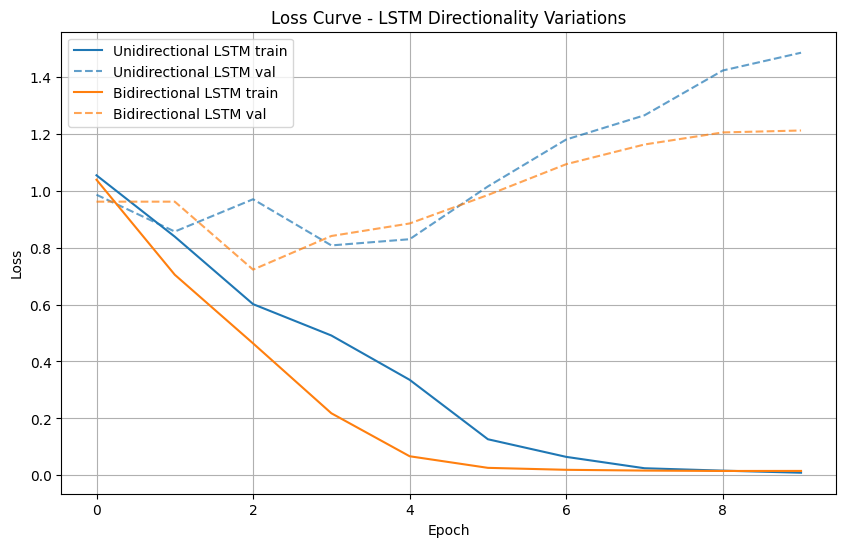

Unidirectional: Macro F1 = 0.6860
Bidirectional: Macro F1 = 0.7254


In [60]:
num_classes_val = len(label_encoder.classes_)

model_unidir = build_lstm_model(num_lstm_layers=3, lstm_units=64, bidirectional=False, num_classes=num_classes_val)
model_bidir = build_lstm_model(num_lstm_layers=3, lstm_units=64, bidirectional=True, num_classes=num_classes_val)

hist_uni, f1_uni = train_lstm_model(model_unidir, X_train_vec, y_train, X_valid_vec, y_valid, X_test_vec, y_test, "Unidirectional LSTM")
hist_bi, f1_bi = train_lstm_model(model_bidir, X_train_vec, y_train, X_valid_vec, y_valid, X_test_vec, y_test, "Bidirectional LSTM")

histories_dir_collected = [hist_uni, hist_bi]
labels_dir_collected = ["Unidirectional LSTM", "Bidirectional LSTM"]
f1_scores_dir_collected = [f1_uni, f1_bi]
direction_labels_collected = ["Unidirectional", "Bidirectional"]

plot_multi_loss(histories_dir_collected, labels_dir_collected, title='Loss Curve - LSTM Directionality Variations')

for dir_label, f1_val in zip(direction_labels_collected, f1_scores_dir_collected):
    print(f'{dir_label}: Macro F1 = {f1_val:.4f}')

## Forward Propagation Implementation From Scratch

In [61]:
keras_model_scratch = build_lstm_model(num_lstm_layers=1, lstm_units=64, bidirectional=False, num_classes=len(label_encoder.classes_))
keras_model_scratch.fit(
    X_train_vec, y_train,
    validation_data=(X_valid_vec, y_valid),
    epochs=10,
    batch_size=32,
    verbose=0
)
result_weights = keras_model_scratch.get_weights()
keras_model_scratch.summary()

c:\Users\maula\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_47 (Embedding)        │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_106 (LSTM)                 │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,988,811 (15.22 MB)

 Trainable params: 1,329,603 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,659,208 (10.14 MB)

In [62]:
def embedding_forward(x, embedding_matrix):
    return embedding_matrix[x]

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def dropout_forward(x, rate):
    # Pass-Through
    return x

def dense_forward(x, W, b):
    return np.dot(x, W) + b

def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def lstm_forward(x, W, U, b, mask):
    batch_size, seq_len, input_dim = x.shape
    units = U.shape[0]
    
    h = np.zeros((batch_size, units))
    c = np.zeros((batch_size, units))
    
    for t in range(seq_len):
        xt = x[:, t, :]
        current_token_mask = mask[:, t].reshape(-1, 1)

        ht_minus_1 = np.copy(h)
        ct_minus_1 = np.copy(c)

        z = np.dot(xt, W) + np.dot(ht_minus_1, U) + b
        
        i = sigmoid(z[:, :units])
        f = sigmoid(z[:, units:2*units])
        a = np.tanh(z[:, 2*units:3*units])
        o = sigmoid(z[:, 3*units:])
        
        state = f * ct_minus_1 + i * a
        out = o * np.tanh(state)
        
        c = np.where(current_token_mask, state, ct_minus_1)
        h = np.where(current_token_mask, out, ht_minus_1)
        
    return h

In [63]:
embedding_matrix = result_weights[0]
lstm_W = result_weights[1]
lstm_U = result_weights[2]
lstm_b = result_weights[3]
dense_W = result_weights[4]
dense_b = result_weights[5]

X_test_vec_np = X_test_vec.numpy() if hasattr(X_test_vec, 'numpy') else np.array(X_test_vec)

emb_out = embedding_forward(X_test_vec_np, embedding_matrix)
input_mask = (X_test_vec_np != 0) 
lstm_out = lstm_forward(emb_out, lstm_W, lstm_U, lstm_b, input_mask)
drop_out = dropout_forward(lstm_out, rate=0.5)
dense_out = dense_forward(drop_out, dense_W, dense_b)

probs_scratch = softmax(dense_out)
y_pred_scratch = np.argmax(probs_scratch, axis=1)

# Compare with Library
probs_keras = keras_model_scratch.predict(X_test_vec)
y_pred_keras = np.argmax(probs_keras, axis=1)

f1_scratch = macro_f1(y_test, y_pred_scratch)
f1_keras = macro_f1(y_test, y_pred_keras)

print(f'From-scratch LSTM Macro F1-score: {f1_scratch:.4f}')
print(f'Keras LSTM Macro F1-score: {f1_keras:.4f}')
print('Prediction equal?', np.all(y_pred_scratch == y_pred_keras))
if (np.all(y_pred_scratch != y_pred_keras)):
    print('Are probabilities close (within 1e-5)?', np.allclose(probs_scratch, probs_keras, atol=1e-5))

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
From-scratch LSTM Macro F1-score: 0.7585
Keras LSTM Macro F1-score: 0.7585
Prediction equal? True
